In [3]:
%load_ext load_style
%load_style talk.css

In [4]:
%matplotlib inline

# Streamfunction and velocity potential from zonal and meridional wind component

[windspharm](http://ajdawson.github.io/windspharm/) is a Python library developed by 
[Andrew Dawson](http://ajdawson.github.io/) which provides an pythonic interface to the [pyspharm](https://code.google.com/p/pyspharm/) module, which is basically a bindings to the [spherepack] Fortran library

**Installation** 

1) Download and unpack [pyspharm](https://code.google.com/p/pyspharm/)


2) Download **spherepack** from [http://www2.cisl.ucar.edu/resources/legacy/spherepack](http://www2.cisl.ucar.edu/resources/legacy/spherepack) and unpack

3) copy all the Fortran files in `[path_to_spherepack]/spherepack3.2/src` to `[path_to_pyspharm]/pyspharm-1.0.8/src` 

4) install **pyspharm**: 

```
pyspharm-1.0.8  ᐅ python setup.py build
pyspharm-1.0.8  ᐅ python setup.py install

```

5) install **windspharm**

```
ᐅ pip install windspharm
```


windspharm has 3 different `interfaces`: 
    
        
+ **`standard`**: expects numpy arrays as inputs
+ **`cdms`**: [cdms2](http://esg.llnl.gov/cdat/cdms_html/cdms-2.htm) objects (cdms2 is a class for opening netcdf files [amongst other formats]) part of the [cdat-lite](http://proj.badc.rl.ac.uk/cedaservices/wiki/CdatLite) package or [UV-CDAT](http://uvcdat.llnl.gov/) distribution)
+ **`iris`**: [iris](http://scitools.org.uk/iris/index.html) cubes

We are going to use [xray](https://github.com/xray/xray) here, and thus use the standard interface, passing the underlying numpy arrays

In [5]:
from windspharm.standard import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim

### usual imports

In [6]:
import os, sys
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm

In [7]:
dpath = os.path.join(os.environ.get('HOME'), 'data/NCEP1')

### defines a function to plot a 2D field map

In [8]:
def plot_field(X, lat, lon, vmin, vmax, step, cmap=plt.get_cmap('jet'), ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(10, (X.shape[0] / float(X.shape[1])) * 10))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 60), labels=[0,0,0,1])
        m.drawparallels([-40, 0, 40], labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)

## load the wind data using xray

In [13]:
import xray; print(xray.__version__)

0.4.0rc1


In [14]:
dset_u = xray.open_dataset(os.path.join(dpath,'uwnd.2014.nc')) 
dset_v = xray.open_dataset(os.path.join(dpath,'vwnd.2014.nc')) 

In [15]:
dset_u = dset_u.sel(level=200)
dset_v = dset_v.sel(level=200)

In [16]:
dset_u = dset_u.mean('time')

In [17]:
dset_v = dset_v.mean('time')

In [18]:
lats = dset_u['lat'].values
lons = dset_u['lon'].values

In [19]:
uwnd = dset_u['uwnd'].values
vwnd = dset_v['vwnd'].values

In [20]:
uwnd, uwnd_info = prep_data(uwnd, 'yx')
vwnd, vwnd_info = prep_data(vwnd, 'yx')

# It is also required that the latitude dimension is north-to-south. Again the
# bundled tools make this easy.
lats, uwnd, vwnd = order_latdim(lats, uwnd, vwnd)

In [21]:
lons, lats = np.meshgrid(lons, lats)

In [22]:
w = VectorWind(uwnd, vwnd)

In [23]:
sf, vp = w.sfvp()

In [24]:
vp = vp * 10e-6

In [25]:
sf = sf * 10e-6

In [26]:
m = bm(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,\
            lat_ts=0,resolution='c')

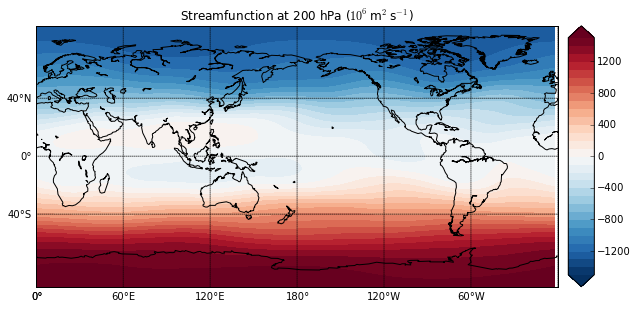

In [29]:
plot_field(sf.squeeze(), lats, lons, -1500, 1500, 100, cmap=plt.get_cmap('RdBu_r'), \
               title="Streamfunction at 200 hPa ($10^6$m$^2$s$^{-1}$)", grid=True)

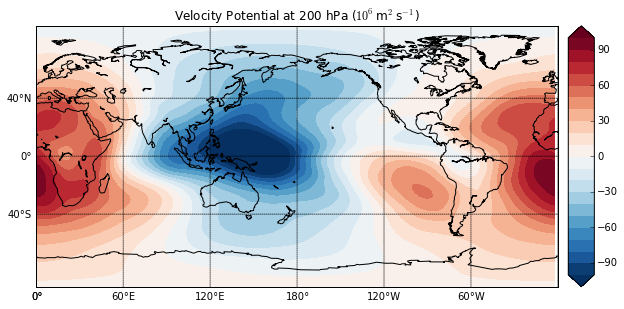

In [30]:
plot_field(vp.squeeze(), lats, lons, -100, 100, 10, cmap=plt.get_cmap('RdBu_r'), \
               title="Velocity Potential at 200 hPa ($10^6$m$^2$s$^{-1}$)", grid=True)